# 1. Monte Carlo Methods

The Monte Carlo method is a computational algorithm that relies on repeated random sampling to obtain numerical results. The basic idea is to use randomness to solve problems that might be deterministic in principle. Monte Carlo methods are used in various fields such as physics, finance, and engineering for numerical integration, optimization, and simulation.

## 1.1 Key Concepts
1. **Random Sampling:**  Randomly generating inputs to a function to simulate a process.
2. **Statistical Analysis:** Using the results of random sampling to infer properties of the function or process.
3. **Law of Large Numbers:** The more samples you use, the closer the estimate will be to the true value.

Given i.i.d. random variables $X_1, \ldots, X_n$. We define the mean
\begin{equation*}
\bar{X}:= \frac{1}{n} \sum_{i=1}^{n} X_i.
\end{equation*}

By the strong law of large numbers it holds:
\begin{equation}
\bar{X} \rightarrow \mathbb{E}[X] \ \ \textit{a.s.}
\end{equation}

A basic **Monte Carlo (MC) simualtion** for $n$ i.i.d. copies of a given random variable $X$ uses the estimator $\bar{X}$ for estimating the mean $\mathbb{E}[X]$.

Let us consider a function $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$ (measurable) that represents the model that we are interested in, i.e. the source location of a tsunami. If we like to estimate $\mathbb{E}[f(X)]$ the MC estimator is given by 
\begin{equation}
\hat{F}^{MC} = \frac{1}{n} \sum_{i=1}^{n} f(X_i).
\end{equation}

**UM-Bridge context:** The model function $f$ represents the **server** side while we refer to the MC estimator $\hat{F}^{MC}$ as the **client**.

In the following we give some basic MC simulation for a sample of normal distributed random variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of random variables
N = 1000

# Generate N normal distributed random variables between 0 and 1
X = np.random.normal(loc=0.5, scale=0.1, size=N)

# Calculate the mean of the random variables
mean_X = np.mean(X)

# Expected value for a normal distribution with mean = 0.5
expected_value = 0.5

print(f"Calculated mean: {mean_X}")
print(f"Expected mean: {expected_value}")

Calculated mean: 0.4970699261835589
Expected mean: 0.5


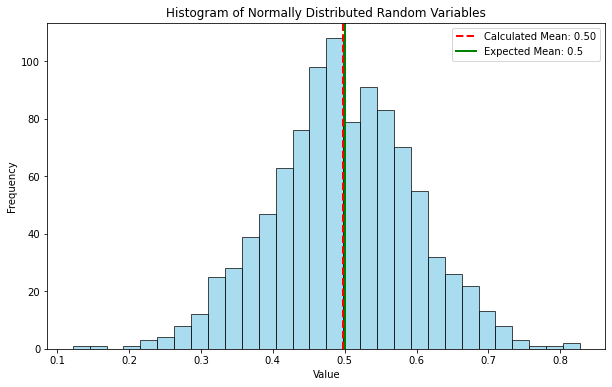

In [2]:
# Plot
plt.figure(figsize=(10, 6))
plt.hist(X, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mean_X, color='red', linestyle='dashed', linewidth=2, label=f'Calculated Mean: {mean_X:.2f}')
plt.axvline(expected_value, color='green', linestyle='solid', linewidth=2, label='Expected Mean: 0.5')
plt.title('Histogram of Normally Distributed Random Variables')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

## 1.2 UM-Bridge Integration

In this subsection we use the MC simulation for estimating an integral. First we give the implementation of the considered model, which is the one dimensional function $f: \mathbb{R} \rightarrow \mathbb{R}$, where $f(x) = \sin(2\pi x)$.

In [ ]:
# umbridge model (server)
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import umbridge
import time
import os

class Testmodel(umbridge.Model):# Define the model function f(x)=sin(2*pi*x)

    def __init__(self):
        super().__init__("forward")

    def get_input_sizes(self, config):
        return [1]

    def get_output_sizes(self, config):
        return [1]

    def __call__(self, parameters, config):
        # Sleep for number of milliseconds defined in env var
        time.sleep(int(os.getenv("TEST_DELAY", 0)) / 1000)

        posterior = np.sin(2 * np.pi * parameters[0][0])
        return [[posterior]]

    def supports_evaluate(self):
        return True

testmodel = Testmodel()

umbridge.serve_models([testmodel], 4244) # start model server

======== Running on http://0.0.0.0:4244 ========
(Press CTRL+C to quit)


We are interested in the value of the integral $\int_{0}^{1} f(x) \textit{d}x$. We know by simple analysis calculations that this equals $0$. For the MC simulation we consider $N$ uniform distributed random variables $X_i \sim \mathscr{U}([0,1])$, $i=1,...,N$. Then we calculate the MC estimator
\begin{equation}
\hat{F}^{MC} = \frac{1}{N} \sum_{i=1}^{N} f(x_i)
\end{equation}
where $x_i$ are realizations of the random variables $X_i$. We note that $\mathbb{E}[f(X_i)] = \int_{0}^{1} f(x) \textit{d}x$. Thus, we obtain an unbiased estimator for the integral.

In [4]:
# umbridge client
import numpy as np
import umbridge

model = umbridge.HTTPModel("http://localhost:4242", "forward")

N = 100 # Number of samples

# Monte Carlo simulation

# Generate N random samples from a uniform distribution over [0, 1] and convert each to a list
parameters = [np.random.rand(1).tolist() for _ in range(N)]
print("First ten parameters:", parameters[:10], "\n") # print first 10 parameters

mc_values = [model([parameters])[0][0] for parameters in parameters]  # model evaluation for each parameter
print("First ten model evaluations:", mc_values[:10], "\n")

mc_mean = np.mean(mc_values)  # calculate mean
print("MC estimator:", mc_mean, "\n")

ConnectionError: HTTPConnectionPool(host='localhost', port=4242): Max retries exceeded with url: /Info (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc5303c4c10>: Failed to establish a new connection: [Errno 61] Connection refused'))

**Remark:** The convergence of the basic Monte Carlo method is always dimension independent. (In our example we considered a one dimensional function.) (No smoothness is needed!) However, the order is too slow: $\mathscr{O}(N^{-1/2})$. Quasi-Monte Carlo can also be dimension independent and the convergence order is (almost) $\mathscr{O}(N^{-1})$, but requires also (some) smoothness.